## Strange Network Development

In [1]:
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

Using TensorFlow backend.


In [123]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

Assign your specific GPU so we don't overlap

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [5]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

Ingest the landsat imagery stacked into yearly seasonal tiles

In [6]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [7]:
tile_size = 5
tile_list = ['028012', '029011', '028011']
class_count = 6
epochs = 200
batch_size = 25

# The next two cells are for making pixels and prepping them for training (balancing)
### This is unnecessary to run because I already saved them to text files so now you load them

In [135]:
px = rnn_pixels.make_pixels(tile_size, tile_list)
px_to_use = px[:3000000]
pixels = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, px_to_use, tile_size, buffer_pix=1)

In [136]:
len(pixels), len(px)

(1036509, 3000000)

In [160]:
# gets balanced pixels locations 
w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = w_tile_gen.tile_generator(pixels, batch_size=1, flatten=True, canopy=False)
total_labels = list()
count = 0
#buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}

while count < len(pixels):
        image_b, label_b = next(w_generator)
        label_b = np.argmax(label_b)
        buckets[label_b].append(pixels[count]) # appends pixels to dictionary
        total_labels.append(label_b)
        count+=1
total_labels = np.asarray(total_labels)
total_labels = total_labels.reshape(len(total_labels))
#weights_list = class_weight.compute_class_weight('balanced', np.unique(total_labels), total_labels)
count = 0 
for z, j in buckets.items():
    print(len(j))
    count += len(j)
print(count) 
use_px = []
count_per_class = 1500
use_px+=buckets[0][:count_per_class]
use_px+=(buckets[1][:count_per_class])
use_px+=(buckets[2][:count_per_class])
use_px+=(buckets[3][:count_per_class])
use_px+=(buckets[4][:count_per_class])
use_px+=(buckets[5][:count_per_class])
random.shuffle(use_px)
train_px, val_px, test_px = rnn_pixels.train_val_test_split(use_px, 0.7, 0.7)

416533
4379
408096
186823
1500
19178
1036509
train:6300 val:1889 test:1378


In [161]:
len(buckets[4])

1500

In [162]:
len(use_px)

9000

# Load pixels

In [163]:
#train_px, val_px, test_px = util.read_txt(['train_px.txt', 'val_px.txt', 'test_px.txt'])
#train_px = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, train_px, tile_size)
#val_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, val_px, tile_size)
#test_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, test_px, tile_size)

### Create the RNN

In [164]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp
    

In [165]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=2, activation='elu', return_sequences=True)(input_tensor_tile)
    # batch norm
    cnn_layer2 = ConvLSTM2D(64, kernel_size=2, activation='elu', return_sequences=False) (cnn_layer1)
    maxpool = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid') (cnn_layer2)
    flatten = Flatten()(maxpool)
    concat = concatenate([final_block, flatten])
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (concat)
    canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover, canopy])
    return model

In [166]:
model = make_MLT_dense((4,7),(4,tile_size,tile_size,7), 6)
#model.load_weights('mlt_dense_model.hdf5')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rnn_input (InputLayer)          (None, 4, 7)         0                                            
__________________________________________________________________________________________________
lstm_28 (LSTM)                  (None, 4, 12)        960         rnn_input[0][0]                  
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 4, 19)        0           rnn_input[0][0]                  
                                                                 lstm_28[0][0]                    
__________________________________________________________________________________________________
lstm_29 (LSTM)                  (None, 4, 12)        1536        concatenate_28[0][0]       

In [167]:
#model = keras.models.load_model('dense_model.h5')

#### Train the Model

In [168]:
#filepath = 'mlt_dense_model_pcg.hdf5'#your filepath here
#checkpoint = ModelCheckpoint(filepath, monitor='val_landcover_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [169]:
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy', 'canopy':'mae'}, metrics={'landcover':['accuracy'], 'canopy':['mae']}, loss_weights={"landcover":1, "canopy":1})

In [ ]:
history = model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                    steps_per_epoch=len(train_px) // batch_size // 10, epochs=epochs // 5, verbose=1,
                   validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                  validation_steps=len(val_px) // batch_size // 10)# callbacks=callbacks_list)# class_weight=weights_list)# callbacks=callbacks_list) #class_weight=weights, callbacks=callbacks_list) 

Epoch 1/40
25/25 [==============================] - 3s 124ms/step - loss: 0.0252 - landcover_loss: 0.0077 - canopy_loss: 0.0175 - landcover_acc: 0.9984 - canopy_mean_absolute_error: 0.0175 - val_loss: 0.4535 - val_landcover_loss: 0.4206 - val_canopy_loss: 0.0329 - val_landcover_acc: 0.9257 - val_canopy_mean_absolute_error: 0.0329
Epoch 2/40
25/25 [==============================] - 3s 104ms/step - loss: 0.0138 - landcover_loss: 0.0015 - canopy_loss: 0.0123 - landcover_acc: 1.0000 - canopy_mean_absolute_error: 0.0123 - val_loss: 0.3592 - val_landcover_loss: 0.3271 - val_canopy_loss: 0.0321 - val_landcover_acc: 0.9314 - val_canopy_mean_absolute_error: 0.0321
Epoch 3/40
25/25 [==============================] - 3s 103ms/step - loss: 0.0173 - landcover_loss: 0.0020 - canopy_loss: 0.0154 - landcover_acc: 1.0000 - canopy_mean_absolute_error: 0.0154 - val_loss: 0.2981 - val_landcover_loss: 0.2803 - val_canopy_loss: 0.0178 - val_landcover_acc: 0.9429 - val_canopy_mean_absolute_error: 0.0178
Epoc

Epoch 26/40
25/25 [==============================] - 3s 102ms/step - loss: 0.0641 - landcover_loss: 0.0460 - canopy_loss: 0.0181 - landcover_acc: 0.9856 - canopy_mean_absolute_error: 0.0181 - val_loss: 0.2610 - val_landcover_loss: 0.2257 - val_canopy_loss: 0.0353 - val_landcover_acc: 0.9371 - val_canopy_mean_absolute_error: 0.0353
Epoch 27/40
25/25 [==============================] - 3s 102ms/step - loss: 0.0761 - landcover_loss: 0.0520 - canopy_loss: 0.0242 - landcover_acc: 0.9888 - canopy_mean_absolute_error: 0.0242 - val_loss: 0.4697 - val_landcover_loss: 0.4221 - val_canopy_loss: 0.0476 - val_landcover_acc: 0.9314 - val_canopy_mean_absolute_error: 0.0476
Epoch 28/40
25/25 [==============================] - 3s 101ms/step - loss: 0.0610 - landcover_loss: 0.0390 - canopy_loss: 0.0220 - landcover_acc: 0.9888 - canopy_mean_absolute_error: 0.0220 - val_loss: 0.5975 - val_landcover_loss: 0.5661 - val_canopy_loss: 0.0313 - val_landcover_acc: 0.9029 - val_canopy_mean_absolute_error: 0.0313
E

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['landcover_acc'])
plt.plot(history.history['val_landcover_acc'])
plt.title('Model LC accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['canopy_mean_absolute_error'])
plt.plot(history.history['val_canopy_mean_absolute_error'])
plt.title('Model canopy error')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.plot(history.history['landcover_loss'])
plt.plot(history.history['val_landcover_loss'])
plt.plot(history.history['canopy_loss'])
plt.plot(history.history['val_canopy_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val', 'Train LC', 'Val LC', 'Train Canopy', 'Val Canopy'], loc='upper left')
plt.show()

### Inspect Training Data

In [171]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True), steps=len(train_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True)

6300/6300 [==============================] - 197s 31ms/step


In [172]:
lc_predictions_train = np.asarray(predictions[0])
canopy_pred_train = np.asarray(predictions[1])
lc_predictions_train = np.argmax(lc_predictions_train,axis=-1)

In [173]:
lc_lab_train = np.empty(lc_predictions_train.shape)
canopy_true_train = np.empty(canopy_pred_train.shape)
count = 0
while count < len(lc_predictions_train):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        canopy_true_train[count] = label_b['canopy']
        lc_lab_train[count] = label_lc
        count += 1
label_index = lc_lab_train.reshape(len(train_px))
pred_index = lc_predictions_train.reshape(len(train_px))

((array([4850.,   86.,  106.,   79.,   59.,   40.,   61.,   79.,  188.,
          752.]),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
  <a list of 10 Patch objects>),
 (array([  28., 4883.,  100.,  103.,   67.,   49.,   69.,  112.,  869.,
           20.]),
  array([-0.17, -0.04,  0.09,  0.22,  0.34,  0.47,  0.6 ,  0.73,  0.86,
          0.99,  1.12], dtype=float32),
  <a list of 10 Patch objects>))

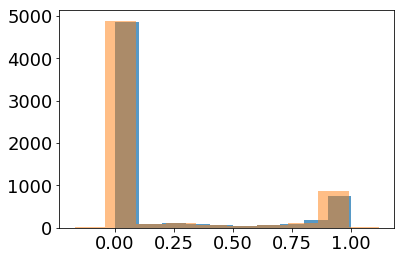

In [174]:
plt.hist(canopy_true_train, alpha=0.75), plt.hist(canopy_pred_train, alpha=0.5)

In [175]:
from sklearn.metrics import r2_score
r2_score(canopy_true_train, canopy_pred_train)

0.9767410428484213

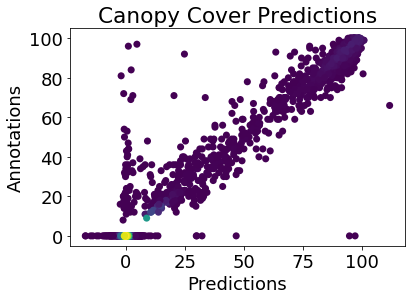

In [176]:
from scipy.stats import gaussian_kde

x = (canopy_pred_train * 100).flatten()
y = (canopy_true_train * 100).flatten()

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()

fig,ax = plt.subplots()
ax.scatter(x,y,c=z,s=50,edgecolor='')
ax.set_xlabel("Predictions")
ax.set_ylabel("Annotations")
ax.set_title("Canopy Cover Predictions")
plt.show()

# Evaluate model

In [177]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True), steps=len(test_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)

1378/1378 [==============================] - 42s 31ms/step


In [178]:
lc_predictions = np.asarray(predictions[0])
canopy_pred = np.asarray(predictions[1])
lc_predictions = np.argmax(lc_predictions,axis=-1)

In [179]:
lc_lab = np.empty(lc_predictions.shape)
canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_lc
        count += 1
label_index = lc_lab.reshape(len(test_px)*1*1)
pred_index = lc_predictions.reshape(len(test_px)*1*1)

Accuracy is 0.9375907111756169


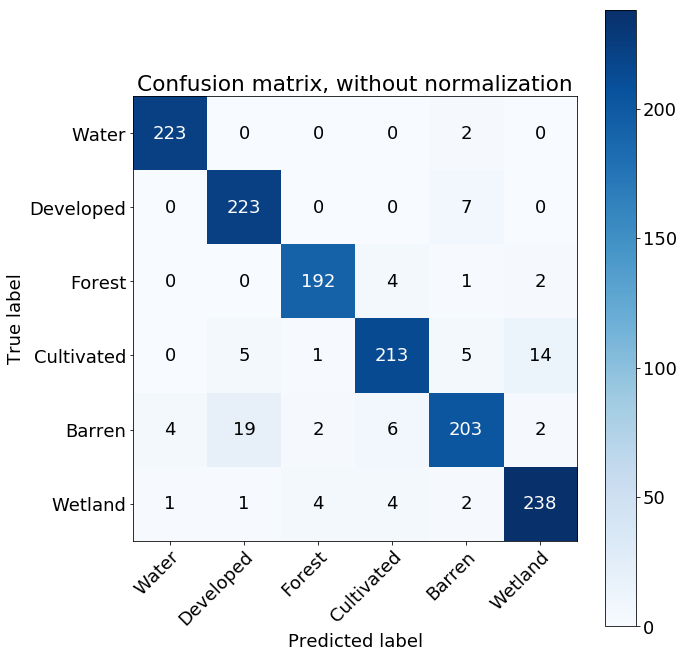

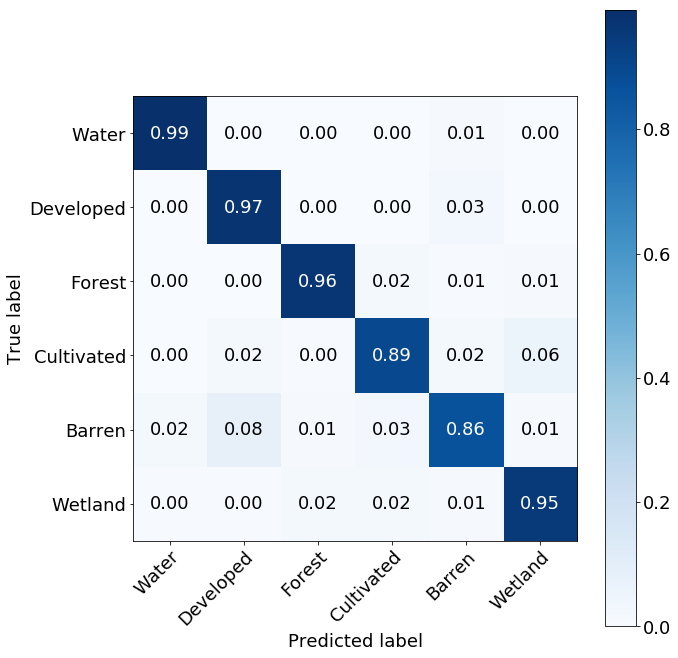

In [180]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary)
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary,
                      normalize=True,
                          title=" ")
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("Accuracy is {}".format(count/len(label_index)))

plt.savefig("confusion_matrix.png", dpi=1000)

In [181]:
total = 0
tot = 0
for count in range(len(canopy_pred)):
    if canopy_true[count] != 0 and canopy_pred[count] !=0:
        if canopy_pred[count] < 0:
            canopy_pred[count] = 0
        total+= np.absolute(canopy_pred[count] - canopy_true[count])
        tot+=1
print(total/tot)

[0.11]


In [182]:
label_index.shape

(1378,)

In [183]:
import pandas as pd
import seaborn as sns
pred_df = pd.DataFrame({'lc_pred': pred_index,
                        'lc_true': label_index,
                        'canopy_pred': canopy_pred.flatten(),
                        'canopy_true': canopy_true.flatten()})
pred_df[pred_df["lc_true"] == 0].head()

,canopy_pred,canopy_true,lc_pred,lc_true
4,-0.002281,0.0,0,0.0
19,-0.001220,0.0,0,0.0
20,-0.002402,0.0,0,0.0
22,-0.002054,0.0,0,0.0
28,-0.002187,0.0,0,0.0


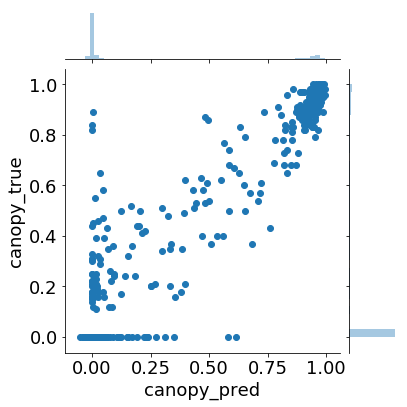

In [184]:
sns.jointplot(x=pred_df['canopy_pred'][pred_df['lc_true']!=0], y=pred_df['canopy_true'][pred_df['lc_true']!=0], kind='scatter')

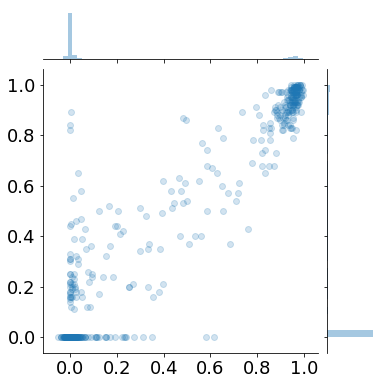

In [185]:
x=pred_df['canopy_pred'][pred_df['lc_true']!=0]
y=pred_df['canopy_true'][pred_df['lc_true']!=0]

from scipy.stats import gaussian_kde

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

#ax.set_xlabel("Predictions")
#ax.set_ylabel("Annotations")
#ax.set_title("Canopy Cover Predictions")

g = sns.jointplot(x,y, kind='scatter', alpha=0.2)
#g.ax_joint.scatter(x=pred_df['canopy_pred'][pred_df['lc_true']!=0], y=pred_df['canopy_true'][pred_df['lc_true']!=0])
g.ax_joint.set_xticks(np.linspace(0,1,6))
g.ax_joint.set_xlabel("")
g.ax_joint.set_ylabel("")

plt.savefig("canopy_regression.png", dpi=1000)

(array([1102.,   28.,   16.,   11.,    9.,   12.,   12.,    8.,   28.,
         152.]),
 array([-0.05,  0.05,  0.16,  0.26,  0.37,  0.47,  0.58,  0.68,  0.79,
         0.89,  0.99], dtype=float32),
 <a list of 10 Patch objects>)

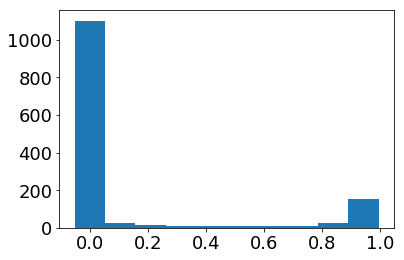

In [186]:
plt.hist(canopy_pred)

(array([1079.,   22.,   26.,   17.,   15.,   18.,   14.,   10.,   49.,
         128.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

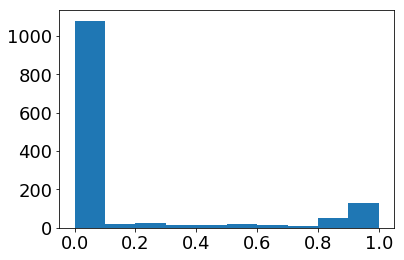

In [187]:
plt.hist(canopy_true)

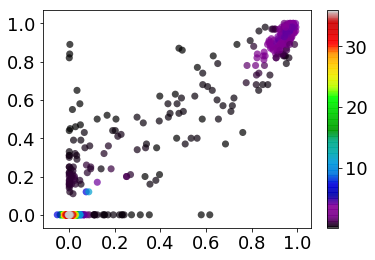

In [188]:
from scipy.stats import gaussian_kde

#x = (canopy_pred * 100).flatten()
#y = (canopy_true * 100).flatten()

x=pred_df['canopy_pred'][pred_df['lc_true']!=0]
y=pred_df['canopy_true'][pred_df['lc_true']!=0]

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots()
im = ax.scatter(x,y,c=z,s=50,edgecolor='', alpha=0.7, cmap="nipy_spectral")
ax.set_xticks(np.linspace(0,1,6))
#ax.set_xlabel("Predictions")
#ax.set_ylabel("Annotations")
#ax.set_title("Canopy Cover Predictions")
plt.colorbar(im, ax=ax)
plt.savefig("canopy_regression.png", dpi=1000)

(array([854.,  22.,  26.,  17.,  15.,  18.,  14.,  10.,  49., 128.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

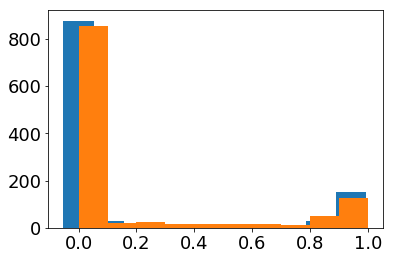

In [189]:
plt.hist(pred_df['canopy_pred'][pred_df['lc_true']!=0])
plt.hist(pred_df['canopy_true'][pred_df['lc_true']!=0])

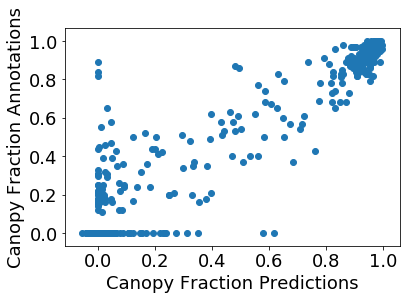

In [190]:
plt.scatter(canopy_pred, canopy_true)
plt.xlabel("Canopy Fraction Predictions")
plt.ylabel("Canopy Fraction Annotations")
plt.savefig("canopy_regression.png", dpi=1000)

In [191]:
from sklearn.metrics import r2_score
r2_score(canopy_true, canopy_pred)

0.9306175388343466

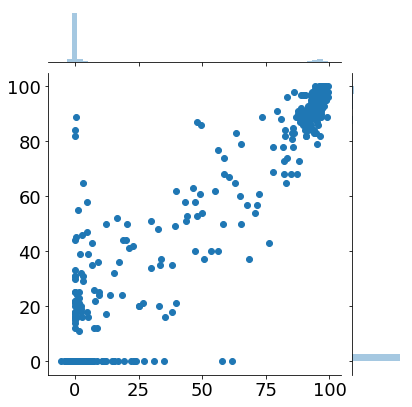

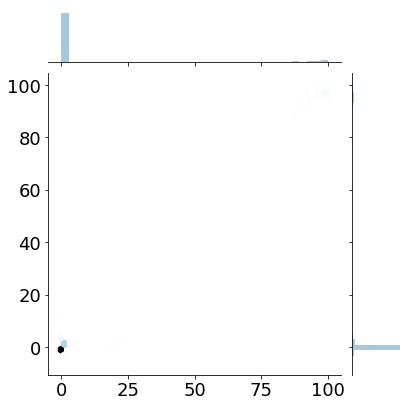

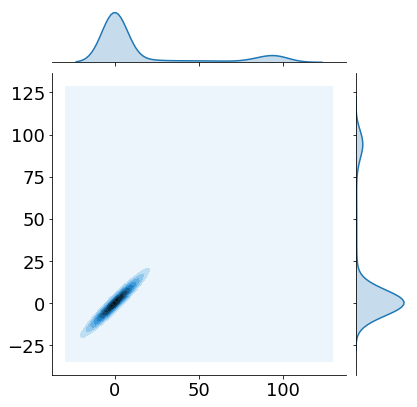

In [192]:
# library & dataset
import seaborn as sns
df = sns.load_dataset('iris')
 

sns.jointplot(y=(canopy_true*100).flatten(), x=(canopy_pred*100).flatten(), kind='scatter')
sns.jointplot(x=(canopy_true*100).flatten(), y=(canopy_pred*100).flatten(), kind='hex')
sns.jointplot(x=(canopy_true*100).flatten(), y=(canopy_pred*100).flatten(), kind='kde')
#plt.savefig("canopy_reg_dist_cont.png", dpi=1000)